In [ ]:
import os
# Find the latest version of spark 3.0 from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.0.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu b

In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("M16-Amazon-Challenge-D2").getOrCreate()

In [ ]:
from pyspark import SparkFiles
url = "https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Software_v1_00.tsv.gz"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("amazon_reviews_us_Software_v1_00.tsv.gz"), sep="\t", header=True, inferSchema=True)
df.show()

+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|marketplace|customer_id|     review_id|product_id|product_parent|       product_title|product_category|star_rating|helpful_votes|total_votes|vine|verified_purchase|     review_headline|         review_body|review_date|
+-----------+-----------+--------------+----------+--------------+--------------------+----------------+-----------+-------------+-----------+----+-----------------+--------------------+--------------------+-----------+
|         US|   42605767|R3EFW2STIYIY0I|B00MUTIDKI|     248732228|McAfee 2015 Inter...|        Software|          1|            2|          2|   N|                Y|I was very disapp...|I was very disapp...| 2015-08-31|
|         US|   51771800|R12NR0R5A9F7FT|B00EPACNUG|     531462352|Hallmark Card Stu...|        Software|          5|    

In [ ]:
# Create the vine_table. DataFrame
vine_df = df.select(['review_id','star_rating','helpful_votes','total_votes','vine','verified_purchase'])
vine_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R3EFW2STIYIY0I|          1|            2|          2|   N|                Y|
|R12NR0R5A9F7FT|          5|            0|          0|   N|                Y|
|R1LSH74R9XAP59|          2|            0|          1|   N|                Y|
|R1QXUNTF76K7L6|          2|            0|          0|   N|                Y|
|R2F7DR75PS8NKT|          5|            0|          0|   N|                Y|
|R2C1DJSCC8UFS6|          3|            0|          0|   N|                Y|
|R1AXGS1W4YFXMX|          1|            0|          2|   N|                Y|
|R1XU1B93402SYJ|          1|            1|          1|   N|                Y|
|R2U432NB3OPVR0|          5|            0|          0|   N|                Y|
|R3R6FIMIOQ5SP9|          5|            0|          0|   N|     

In [ ]:
# Filter the data to retrieve all the rows where the total_votes count is equal to or greater than 20
from pyspark.sql.functions import col
vine_total_votes_df = vine_df.filter(col("total_votes") >= 20)

In [ ]:
vine_total_votes_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R26CC1STPSUHBS|          1|           27|         39|   N|                N|
| R7K83D59T9KWS|          1|           16|         26|   N|                N|
|R2ATG5BPVILHUM|          1|           16|         25|   N|                N|
|R1Q71TAM5ZOYTK|          3|           57|         61|   N|                N|
| RR8HYI7C2XKMU|          5|           25|         25|   N|                Y|
|R1VDCSJE4CJJIR|          1|           88|         97|   N|                Y|
|R2PZMSDKOO1Q6W|          1|           29|         43|   N|                Y|
|R39OOYN0DOLINK|          3|           91|        111|   N|                N|
|R1PLNHJZ8BKIBG|          1|           44|         46|   N|                Y|
|R14G4YQXL17REH|          1|            4|         28|   N|     

In [ ]:
# Filter the data to retrieve all all the rows where the number of helpful_votes divided by total_votes is equal to or greater than 50%.
vine_ht_votes_df = vine_total_votes_df.filter(col("helpful_votes")/col("total_votes") >= 0.5)

In [ ]:
vine_ht_votes_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R26CC1STPSUHBS|          1|           27|         39|   N|                N|
| R7K83D59T9KWS|          1|           16|         26|   N|                N|
|R2ATG5BPVILHUM|          1|           16|         25|   N|                N|
|R1Q71TAM5ZOYTK|          3|           57|         61|   N|                N|
| RR8HYI7C2XKMU|          5|           25|         25|   N|                Y|
|R1VDCSJE4CJJIR|          1|           88|         97|   N|                Y|
|R2PZMSDKOO1Q6W|          1|           29|         43|   N|                Y|
|R39OOYN0DOLINK|          3|           91|        111|   N|                N|
|R1PLNHJZ8BKIBG|          1|           44|         46|   N|                Y|
|R3UTVKJF44E0R6|          1|           46|         69|   N|     

In [ ]:
# Filter the data to retrieve all the rows where a review was written as part of the Vine program (paid)
vine_paid_df = vine_ht_votes_df.filter(col('vine') == 'Y')
vine_paid_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R28EIR3Z6RRUNN|          2|           50|         60|   Y|                N|
|R2YO2RESXZEWOF|          4|           24|         25|   Y|                N|
| R8GEE2EW3D6S9|          3|           49|         54|   Y|                N|
|R33W9V1MX6WKPS|          4|           47|         53|   Y|                N|
|R24E3W2ZRIFG8C|          5|           91|         93|   Y|                N|
|R2OR3KIFFG4YWT|          4|           75|         81|   Y|                Y|
|R1RLJAAFOA5MMS|          2|           25|         27|   Y|                N|
| RVYHD7IZ7W99B|          1|           78|         78|   Y|                N|
|R12EV95D2T56HA|          5|           37|         37|   Y|                N|
|R296NVZGV4VZLP|          5|           41|         44|   Y|     

In [ ]:
# Filter the data to retrieve all the rows where a review was not written as part of the Vine program (paid)
vine_unpaid_df = vine_ht_votes_df.filter(col('vine') == 'N')
vine_unpaid_df.show()

+--------------+-----------+-------------+-----------+----+-----------------+
|     review_id|star_rating|helpful_votes|total_votes|vine|verified_purchase|
+--------------+-----------+-------------+-----------+----+-----------------+
|R26CC1STPSUHBS|          1|           27|         39|   N|                N|
| R7K83D59T9KWS|          1|           16|         26|   N|                N|
|R2ATG5BPVILHUM|          1|           16|         25|   N|                N|
|R1Q71TAM5ZOYTK|          3|           57|         61|   N|                N|
| RR8HYI7C2XKMU|          5|           25|         25|   N|                Y|
|R1VDCSJE4CJJIR|          1|           88|         97|   N|                Y|
|R2PZMSDKOO1Q6W|          1|           29|         43|   N|                Y|
|R39OOYN0DOLINK|          3|           91|        111|   N|                N|
|R1PLNHJZ8BKIBG|          1|           44|         46|   N|                Y|
|R3UTVKJF44E0R6|          1|           46|         69|   N|     

In [ ]:
# Determine the total number of paid reviews
from pyspark.sql.functions import count, countDistinct
number_paid = vine_paid_df.agg(countDistinct("review_id")).collect()[0][0]
print(number_paid)

248


In [ ]:
# Determine the total number of unpaid reviews
number_unpaid = vine_unpaid_df.agg(countDistinct("review_id")).collect()[0][0]
print(number_unpaid)

17514


In [ ]:
# Determine the total number of 5-star paid reviews
number_5_paid = vine_paid_df.filter(col("star_rating")== 5).agg(countDistinct("review_id")).collect()[0][0]
print(number_5_paid)

102


In [ ]:
# Determine the total number of 5-star unpaid reviews
number_5_unpaid = vine_unpaid_df.filter(col("star_rating")== 5).agg(countDistinct("review_id")).collect()[0][0]
print(number_5_unpaid)

5154


In [ ]:
# Determine the percentage of 5-star reviews for paid reviews
percent_5_star_paid = number_5_paid / number_paid
print(percent_5_star_paid)

0.4112903225806452


In [ ]:
# Determine the percentage of 5-star reviews for unpaid reviews
percent_5_star_unpaid = number_5_unpaid / number_unpaid
print(percent_5_star_unpaid)

0.29427886262418634


In [ ]:
# Create a dataframe to save the analysis results
vine_analysis_df = spark.createDataFrame([("Paid Reviews",number_paid,number_5_paid,percent_5_star_paid),("Unpaid Reviews",number_unpaid,number_5_unpaid,percent_5_star_unpaid)],["Category", "Number_of_reviews", "Number_of_5-star_reviews","Percent_of_5-star_reviews"])

In [ ]:
vine_analysis_df.show()

+--------------+-----------------+------------------------+-------------------------+
|      Category|Number_of_reviews|Number_of_5-star_reviews|Percent_of_5-star_reviews|
+--------------+-----------------+------------------------+-------------------------+
|  Paid Reviews|              248|                     102|       0.4112903225806452|
|Unpaid Reviews|            17514|                    5154|      0.29427886262418634|
+--------------+-----------------+------------------------+-------------------------+



In [ ]:
# Convert the analysis dataFrame to Pandas dataFrame
vine_analysis_PD = vine_analysis_df.toPandas()
vine_analysis_PD.set_index("Category",inplace=True)


In [ ]:
vine_analysis_PD.head()

,Number_of_reviews,Number_of_5-star_reviews,Percent_of_5-star_reviews
Category,,,
Paid Reviews,248,102,0.411290
Unpaid Reviews,17514,5154,0.294279


In [ ]:
vine_analysis_PD1 = vine_analysis_PD[["Number_of_reviews","Number_of_5-star_reviews"]]
vine_analysis_PD1.head()

,Number_of_reviews,Number_of_5-star_reviews
Category,,
Paid Reviews,248,102
Unpaid Reviews,17514,5154


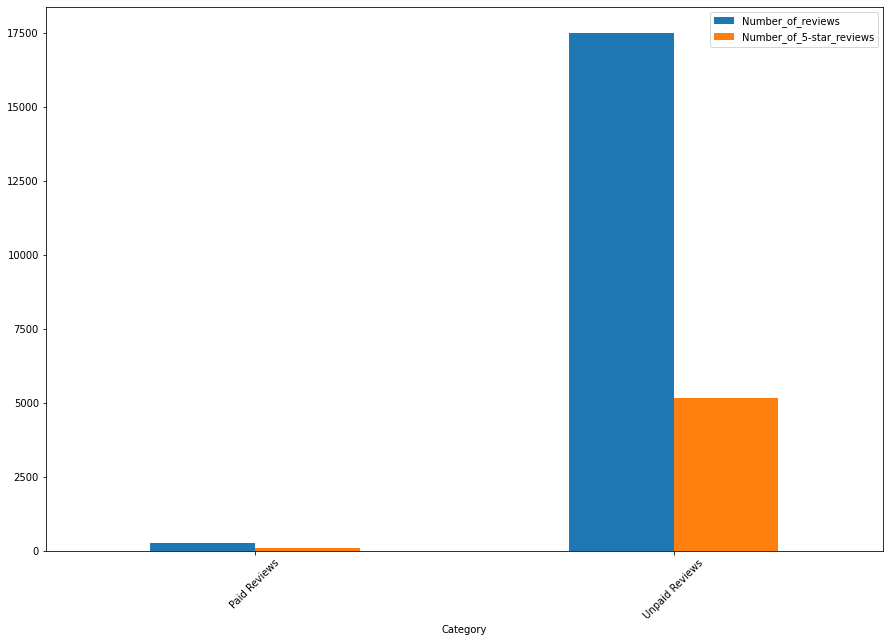

In [ ]:
# Plot the number of paid and unpaid reviews against the number of paid and unpaid 5-star reviews
vine_analysis_PD1.plot.bar(rot=45,figsize=(15, 10))

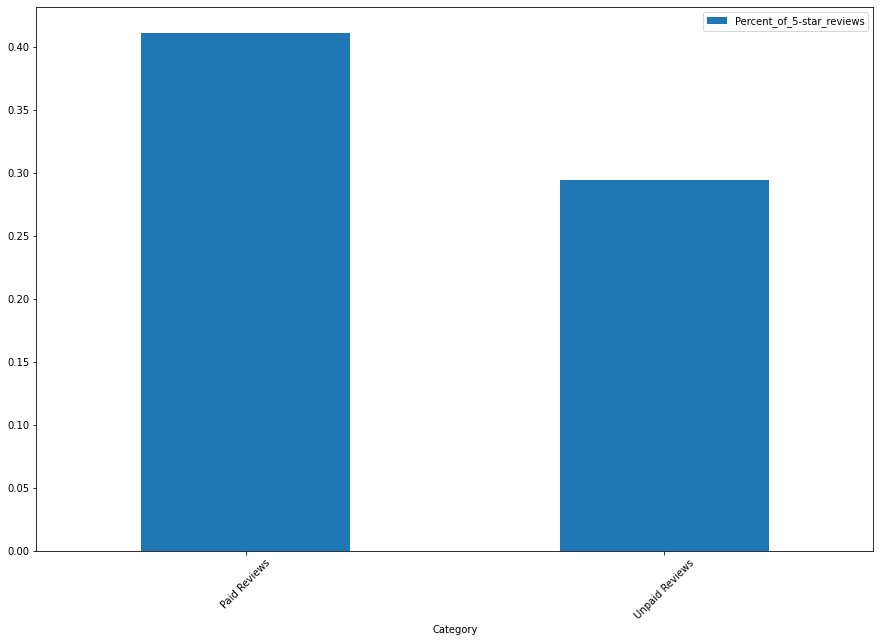

In [ ]:
# Plot the percentage of 5-star reviews
vine_analysis_PD.plot.bar(y="Percent_of_5-star_reviews",figsize=(15, 10), rot=45)